# FastAI Exploration of Freesound 8k
## NOTE: 
This implementation does not use Mel scaling, so its results are less accurate than the Matlab implementation.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
from fastai_audio import *

In [12]:
DATA = Path('/home/zach/Music/urbansound8k')
labels = pd.read_csv(DATA/'train.csv', index_col=0)
tinlabs = pd.read_csv(DATA/'tiny.csv', index_col=0)

In [4]:
n_fft = 1024 # output of fft will have shape [513 x n_frames]
n_hop = 256  # 75% overlap between frames
n_mels = 40 # compress 513 dimensions to 40 via mel frequency scale
sample_rate = 44100

tfms = get_frequency_batch_transforms(n_fft=n_fft, n_hop=n_hop,
                                      n_mels=n_mels, sample_rate=sample_rate)

In [73]:
def label_func(f):
    name = str(f).split("/")[-1][0:-4]
    return labels['Class'][int(name)]

In [89]:
batch_size = 64
data = (AudioItemList
       .from_folder(DATA/"Train")
       .split_by_rand_pct()
       .label_from_func(label_func)
       .databunch(bs=batch_size, tfms=tfms, equal_lengths=False, num_workers=8)
        )

Beginning calculations?
Train lengths calculated
Valid lengths calculated
Fix Lengths calculated


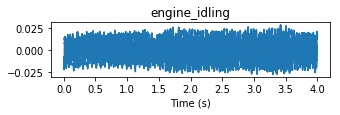

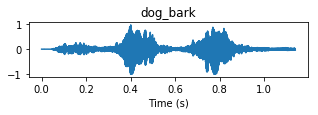

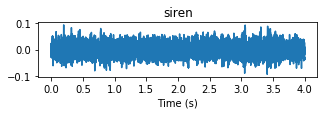

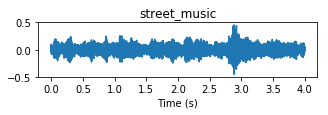

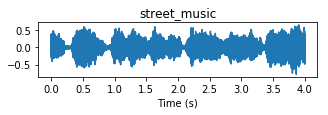

In [76]:
data.show_batch()

In [77]:
data.c, data.classes

(10,
 ['air_conditioner',
  'car_horn',
  'children_playing',
  'dog_bark',
  'drilling',
  'engine_idling',
  'gun_shot',
  'jackhammer',
  'siren',
  'street_music'])

In [114]:
xs, ys = data.one_batch()

In [115]:
xs.shape, ys.shape

(torch.Size([64, 1, 40, 1501]), torch.Size([64]))

In [111]:
learn = create_cnn(data, models.resnet18, metrics=accuracy)

In [70]:
learn.lr_find()
learn.recorder.plot()

In [113]:
learn.fit_one_cycle(5, max_lr=3e-4)

epoch,train_loss,valid_loss,accuracy,time
0,1.878031,1.147626,0.633855,00:25
1,0.977544,0.510962,0.841766,00:26
2,0.547267,0.358347,0.890524,00:24
3,0.303867,0.218287,0.935603,00:25
4,0.174126,0.206829,0.940202,00:25


In [112]:
learn.unfreeze()

In [103]:
learn.fit_one_cycle(5, max_lr=(3e-5, 3e-4, 3e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.582471,0.536862,0.829807,00:24
1,0.518598,0.424596,0.856486,00:25
2,0.367918,0.289901,0.911684,00:25
3,0.180811,0.197951,0.947562,00:25
4,0.088287,0.182097,0.944802,00:25


# Interpretation

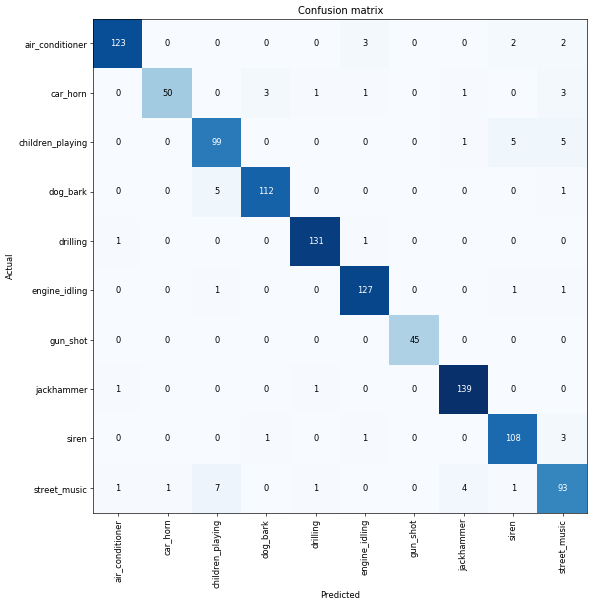

In [104]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10, 10), dpi=60)

In [105]:
interp.most_confused()

[('street_music', 'children_playing', 7),
 ('children_playing', 'siren', 5),
 ('children_playing', 'street_music', 5),
 ('dog_bark', 'children_playing', 5),
 ('street_music', 'jackhammer', 4),
 ('air_conditioner', 'engine_idling', 3),
 ('car_horn', 'dog_bark', 3),
 ('car_horn', 'street_music', 3),
 ('siren', 'street_music', 3),
 ('air_conditioner', 'siren', 2),
 ('air_conditioner', 'street_music', 2),
 ('car_horn', 'drilling', 1),
 ('car_horn', 'engine_idling', 1),
 ('car_horn', 'jackhammer', 1),
 ('children_playing', 'jackhammer', 1),
 ('dog_bark', 'street_music', 1),
 ('drilling', 'air_conditioner', 1),
 ('drilling', 'engine_idling', 1),
 ('engine_idling', 'children_playing', 1),
 ('engine_idling', 'siren', 1),
 ('engine_idling', 'street_music', 1),
 ('jackhammer', 'air_conditioner', 1),
 ('jackhammer', 'drilling', 1),
 ('siren', 'dog_bark', 1),
 ('siren', 'engine_idling', 1),
 ('street_music', 'air_conditioner', 1),
 ('street_music', 'car_horn', 1),
 ('street_music', 'drilling', 1),

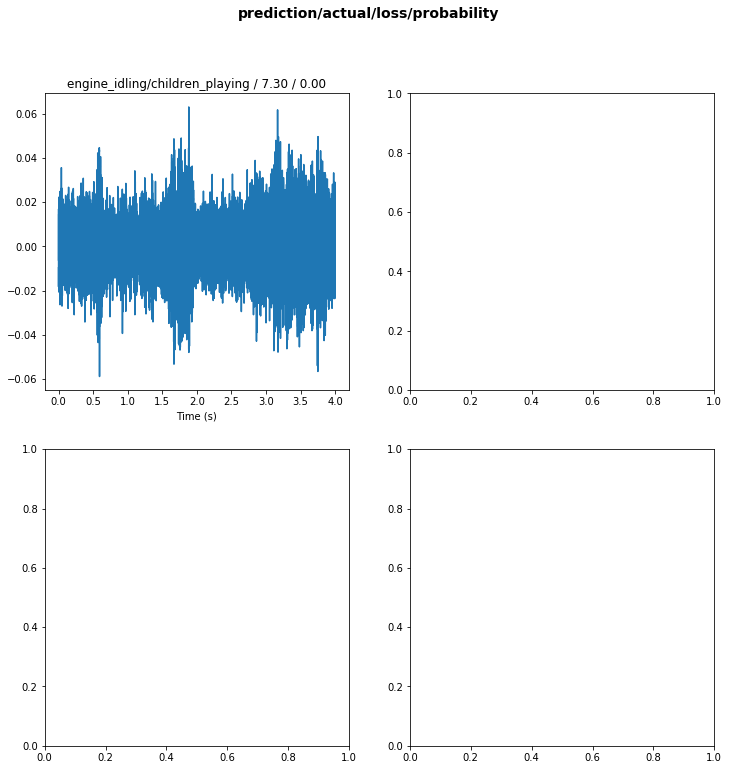

AttributeError: 'AudioClip' object has no attribute 'shape'

In [98]:
interp.plot_top_losses(k=3)

# Torchaudio Test

In [124]:
import torchaudio
from torch import *

In [197]:
def taspec(num):
    x, sr = torchaudio.load(DATA/"Train"/(str(num)+".wav"))
    S = torchaudio.transforms.MelSpectrogram(sr)
    freqs = S.spec(x)
    np = freqs[0,:,:].flip((0, 1)).numpy().swapaxes(1, 0)
    plt.imshow(np, vmin=-1, vmax=1)

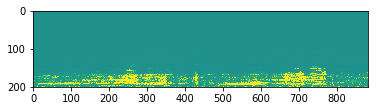

In [208]:
taspec(10)